# Choosing a threshold for classification

There are three types of output that could come out of a classifier: the score, the probability of positive, and the classification.

This notebook illustrates how to select a threshold on the score to generate a classification.

$\newcommand{cdf}{\mathcal{F}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Assume the output of a classifier is Gaussian distributed per class. In other words, the class conditional densities are Gaussian. But assume that the mean prediction is not centered around zero.

Mean values are 1.1523329279795198 (overall), 2.888422453842282 (positive) and 0.9787239753932433 (negative)


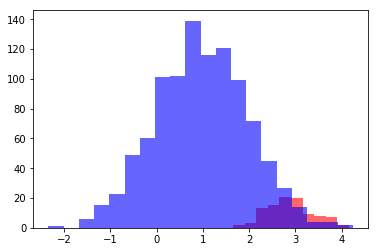

In [2]:
num_pos = 100
num_neg = 1000
y = np.concatenate([-np.ones(num_neg), np.ones(num_pos)])
pos_idx = np.where(y==1)[0]
neg_idx = np.where(y==-1)[0]

def gauss_pos(num_samples, mean=3, stddev=0.5):
    return np.random.normal(loc=mean, scale=stddev, size=num_samples)

def gauss_neg(num_samples, mean=1, stddev=1):
    return np.random.normal(loc=mean, scale=stddev, size=num_samples)

X = np.concatenate([gauss_neg(num_neg), gauss_pos(num_pos)])
print('Mean values are {} (overall), {} (positive) and {} (negative)'.format(np.mean(X), 
                                                                             np.mean(X[pos_idx]), 
                                                                             np.mean(X[neg_idx])))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(X[pos_idx], bins=10, color='red', alpha=0.6)
_ = ax.hist(X[neg_idx], bins=20, color='blue', alpha=0.6)

Fit a Gaussian around each class conditional density

In [3]:
def gauss_fit(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev



## Derivation of confusion matrix based on parametric conditional densities

Based on a continuous decision threshold $t$, let $\cdf_+(t)$ and $\cdf_−(t)$ denote the resulting cumulative distribution functions of the positive and negative populations of decision values, respectively. Further, let $\alpha \in (0, 1)$ be the fraction of positive examples. The confusion matrix can then be rewritten in a parametric form:

| conf. matrix  | actual $+$ | actual $-$ |
|:--------------|:----------:|:----------:|
| predicted $+$ | $\alpha(1-\cdf_+(t))$ | $(1-\alpha)(1-\cdf_-(t))$ |
| predicted $-$ | $\alpha\cdf_+(t)$ | $(1-\alpha)\cdf_-(t)$ |
| total | $\alpha$ | $1-\alpha $ |

Reference:

*Kay H. Brodersen, Cheng Soon Ong, Klaas E. Stephan and Joachim M. Buhmann*
The binormal assumption on precision-recall curves
*International Conference on Pattern Recognition 2010*

### Find a threshold that balances false positive and false negative rates

In other words, find $t$ such that
$$(1-\alpha)(1-\cdf_-(t)) = \alpha\cdf_+(t).$$
Rearranging
$$ \frac{\cdf_+(t)}{1-\cdf_-(t)} = \frac{1}{\alpha} - 1 $$

In [4]:
from scipy.stats import norm

In [5]:
pos_mean, pos_stddev = gauss_fit(X[pos_idx])
pos_fit = norm(loc=pos_mean, scale=pos_stddev)
neg_mean, neg_stddev = gauss_fit(X[neg_idx])
neg_fit = norm(loc=neg_mean, scale=neg_stddev)

### Illustration of how the values look like

In [6]:
min_x = np.min(X)
max_x = np.max(X)
t_vals = np.arange(min_x, max_x, 0.01)
tail_ratio = pos_fit.cdf(t_vals)/neg_fit.sf(t_vals)

alpha = float(num_pos)/float(num_pos+num_neg)
target_ratio = 1/alpha - 1
print(alpha, target_ratio)

0.09090909090909091 10.0


(2, 3)

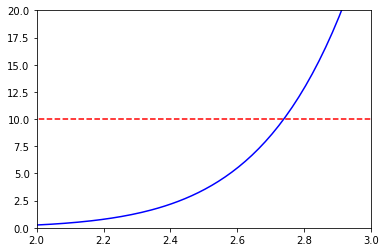

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_vals, tail_ratio, 'b')
ax.plot([min_x, max_x], [target_ratio, target_ratio], 'r--')
ax.set_ylim([0, 2*target_ratio])
ax.set_xlim([2,3])

### Use bisection to find the crossing

In [8]:
from scipy.optimize import bisect

In [9]:
def cost(t, pos_fit, neg_fit, alpha):
    target_ratio = 1/alpha - 1
    tail_ratio = pos_fit.cdf(t)/neg_fit.sf(t)
    return tail_ratio - target_ratio

threshold = bisect(cost, neg_mean, pos_mean, args=(pos_fit, neg_fit, alpha)) 
print(threshold)

2.7383500400319116


## Example classifier from sklearn

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(123)

In [11]:
X, y = load_breast_cancer(return_X_y=True)
print(X.shape, y.shape)
print(np.unique(y))


(569, 30) (569,)
[0 1]


Split into training and test sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# positive and negative indices on the test set
pos_idx = np.where(y_test==1)[0]
neg_idx = np.where(y_test==0)[0]

Create a ```sklearn``` ```LogisticRegression``` classifier, and get the scores

In [13]:
logreg = LogisticRegression(C=1e5, solver='lbfgs')

# Create an instance of classifier and fit the data.
logreg.fit(X_train, y_train)

# Compute the score of the linear function
score_lr = logreg.decision_function(X_test)

# The threshold for logistic regression
print(logreg.intercept_[0])

0.46572970872463704


Plot the histograms of per class scores. We can see from the histograms that the **Gaussian fit is not really a very good assumption**.

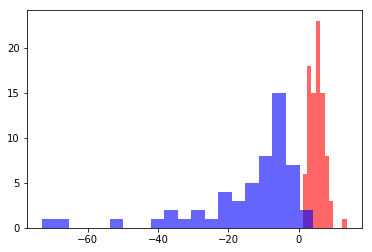

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(score_lr[pos_idx], bins=10, color='red', alpha=0.6)
_ = ax.hist(score_lr[neg_idx], bins=20, color='blue', alpha=0.6)

Fit Gaussians on the class conditional scores of logistic regression

In [15]:
pos_mean, pos_stddev = gauss_fit(score_lr[pos_idx])
pos_fit = norm(loc=pos_mean, scale=pos_stddev)
print(pos_mean, pos_stddev)

neg_mean, neg_stddev = gauss_fit(score_lr[neg_idx])
neg_fit = norm(loc=neg_mean, scale=neg_stddev)
print(neg_mean, neg_stddev)


5.19437536709138 2.090576671099836
-14.42410475054659 15.476974968497286


In [16]:
alpha = len(pos_idx)/len(y_test)
print('Probability of positive class = {}'.format(alpha))
threshold = bisect(cost, neg_mean, pos_mean, args=(pos_fit, neg_fit, alpha)) 
print('Threshold from Gaussian fit = {}'.format(threshold))

Probability of positive class = 0.6223776223776224
Threshold from Gaussian fit = 2.3218836396741027


Investigate the effect of threshold on accuracy

In [17]:
def get_conf_matrix(ypred, ytrue):
    """get confusion matrix from [0, 1] labels"""
    ypred = np.array(ypred)
    ytrue = np.array(ytrue)
    tp =  np.sum((ytrue==1) & (ypred==1))
    tn =  np.sum((ytrue==0)  & (ypred==0))
    fp =  np.sum((ytrue==0)  & (ypred==1))
    fn =  np.sum((ytrue==1)  & (ypred==0))
    
    return np.array([[tp,fp], [fn,tn]])

def accuracy(conf):
    """ compute the accuracy, given a confusion matrix conf
        format: [[TP, FP], [FN, TN]]"""
    
    return (conf[0,0] + conf[1,1]) / np.sum(conf)

def score2class(score, thres):
    """Given a vector of scores, use threshold to predict 0 or 1
    when below or above the threshold respectively"""
    pred = np.zeros(len(score), dtype=int)
    pos_idx = np.where(score > thres)[0]
    pred[pos_idx] = 1
    return pred


In [18]:
pred_default = score2class(score_lr, logreg.intercept_[0])
pred_gaussfit = score2class(score_lr, threshold)

print('Accuracy with default threshold = {}'.format(accuracy(get_conf_matrix(pred_default, y_test))))
print('Accuracy with Gaussian fit threshold = {}'.format(accuracy(get_conf_matrix(pred_gaussfit, y_test))))


Accuracy with default threshold = 0.986013986013986
Accuracy with Gaussian fit threshold = 0.951048951048951
